#### https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

#先將執行目錄更改至models/research/object_detection下
os.chdir('./models/research/object_detection')

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

若遇到各種error，可以試試看重新執行Protobuf Compilation (請確認目前資料夾位置在 model/research下)

```!protoc object_detection/protos/*.proto --python_out=.```

In [3]:
import warnings #隱藏一個 matplotlib 的 warning，不影響結果
warnings.filterwarnings('ignore')

from utils import label_map_util

from utils import visualization_utils as vis_util

## Object detection imports
Here are the imports from the object detection module.

若遇到各種error，可以試試看重新執行Protobuf Compilation (請確認目前資料夾位置在 model/research下)

```!protoc object_detection/protos/*.proto --python_out=.```

In [4]:
import warnings #隱藏一個 matplotlib 的 warning，不影響結果
warnings.filterwarnings('ignore')

from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# 請點選上方的 detection model zoo 來查看有多少 model 可以使用，複製下載連結來更改 DOWNLOAD_BASE
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

## Download Model

In [6]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.
對於 tensorflow graph 概念還不熟悉的同學，可以參考[這篇文章](https://www.cnblogs.com/lienhua34/p/5998853.html)

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [9]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Detection

In [38]:
# 測試的範例圖片放在 models/research/object_detection/test_images/ 的資料夾底下
# 如果想更換圖片，直接改 TEST_IMAGE_PATHS，把檔案名稱放進去即可！
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR,img) for img in os.listdir(PATH_TO_TEST_IMAGES_DIR) if '.jpg' in img]

# Size, in inches, of the output images.
IMAGE_SIZE = (16, 8)

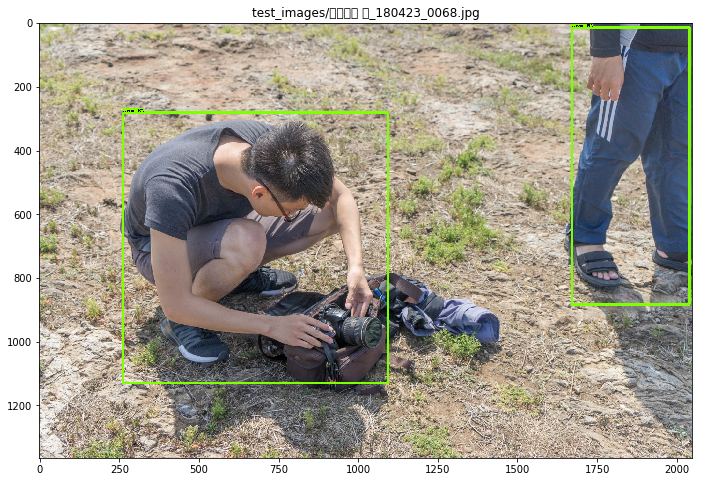

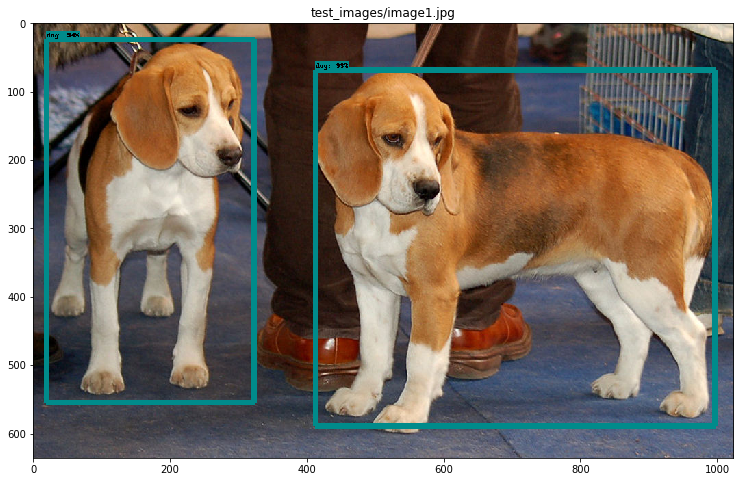

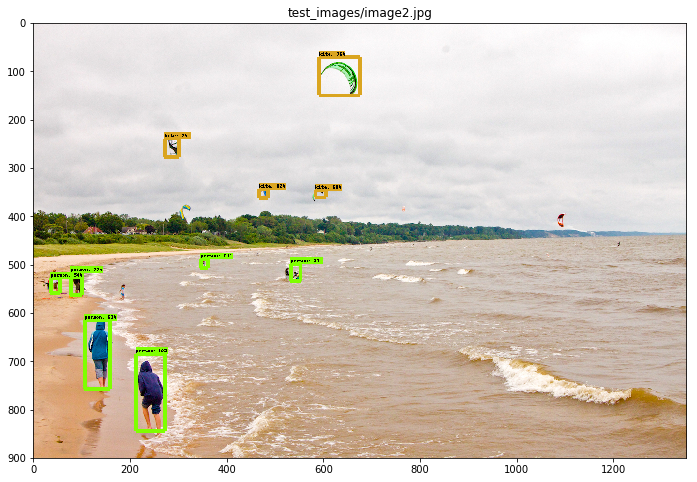

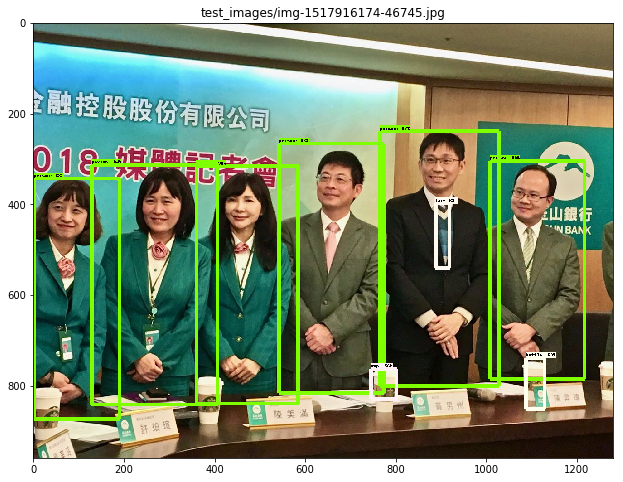

In [39]:
with tf.Session(graph=detection_graph) as sess:
    for IMAGE in TEST_IMAGE_PATHS:
        image = Image.open(IMAGE) # 用 PIL 打開圖片
        image_np = np.array(image).astype(np.uint8) # 將圖片變成 np array
        image_np_expanded = np.expand_dims(image_np, axis=0) # 將圖片維度變為 (1, w, h, 3)。1 對應到 batch
        
        # 將 model 會用到的 input, output 之 tensor 全部找回來
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        # 將圖片送進去模型，就可以得到所有 outputs
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        
        # 把得到的結果 (boxes, classes, scores 全部畫在原本的圖上)
        image_np = vis_util.visualize_boxes_and_labels_on_image_array(
            image_np, np.squeeze(boxes), np.squeeze(classes).astype(np.int32), np.squeeze(scores),
            category_index, use_normalized_coordinates=True, line_thickness=8)
        
        plt.figure(figsize=IMAGE_SIZE)
        plt.title(IMAGE)
        plt.imshow(image_np)
